# License

    Jupyter notebook for computing Pi using Monte Carlo sampling
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

import IPythonMagic
from Timer import Timer

In [2]:
%setup_logging
%cuda_context_handler context

Python version 3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Registering context in user workspace
Creating context
PyCUDA version 2018.1.1
CUDA version (9, 1, 0)
Driver version 10000
Using 'Tesla K80' GPU
 => compute capability: (3, 7)
 => memory: 10994 / 11441 MB available
Created context handle <36602016>
Using CUDA cache dir /home/ubuntu/jupyter_notebooks/Stefano Colombo/MilanoGPU2018/notebooks/cuda_cache


In [7]:
cuda_kernel = """
__global__ void mandelbrot(float* output, unsigned int cols, float dx, float dy, int iterations) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    float x = i*dx - 2;
    float y = j*dy - 1;
    
    float2 z0 = make_float2(x, y);
    float2 z = z0;
    int k = 0;
    
    while (z.x*z.x + z.y*z.y < 25.0 && k < iterations) {
        float tmp = z.x*z.x - z.y*z.y + z0.x;
        z.y = 2*z.x*z.y + z0.y;
        z.x = tmp;
        ++k;
    }
    
    if (k < iterations) {
        output[j*cols+i] = fmod((k - log(log(sqrt(z.x*z.x+z.y*z.y))/log(5.0))/log(2.0)) / 100, 1.0);
    }
    else {
        output[j*cols+i] = 0.0f;
    }
}
"""
module = cuda_compiler.SourceModule(cuda_kernel, options['--use_math_fast'], arch = 'compute_50', \
                                    code='sm_37')
mandelbrot_kernel = module.get_function("mandelbrot");

In [8]:
#Set block and grid size
n = 2048
domain_size = (3*n, 2*n)
block = (8, 8, 1)
grid = (int(domain_size[0]/block[0]), int(domain_size[1]/block[1]), 1)

dx = 3.0 / domain_size[0]
dy = 2.0 / domain_size[1]

#Allocate the output data on the GPU and on the CPU
output = np.empty((domain_size[1],domain_size[0]), dtype=np.float32)
output_gpu = GPUArray(output.shape, np.float32)

#Execute program on device
with Timer("Kernel") as t:
    mandelbrot_kernel(output_gpu, np.int32(domain_size[0]), np.float32(dx), np.float32(dy),\
                      np.int32(100000), block=block, grid=grid)
    context.synchronize()

#Copy data from device to host
output_gpu.get(output)
pass

Kernel: 6331.804991 ms


# Timing
Original: 10071.632147 ms
with fast_math Kernel: 6331.804991 ms
with fast_math and 10 register kernel: 7402.319193 ms
register= variables use at a single time (index x, index y, i, j => 4 in this case)
remember that each register has a limited memory and if I store 10 register to 1 thread, maybe I can run out
of memory => higher time


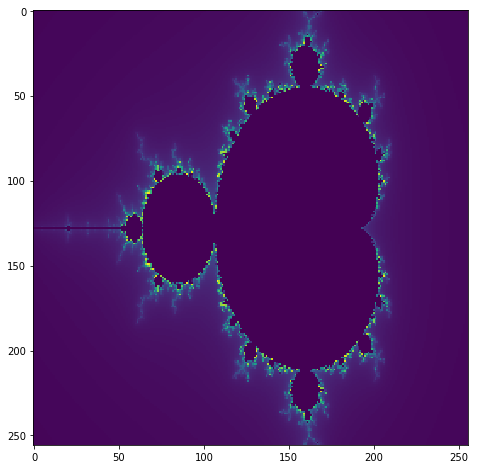

In [9]:
plt.figure(figsize=(12,8))
plt.imshow(output)